# 7. Partial Differential Equations

References:
* Svein Linge & Hans Petter Langtangen: Programming for Computations – Python. Springer (2016). 
    - Chapter 5: Solving Partial Differential Equations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.integrate import odeint

In [3]:
from matplotlib import animation

## Reaction-Diffusion Equation
Linear waves can decay, reflect, and overlay.  
Some nonlinear waves, like neural spike, can travel without decaying.
FitzHugh-Nagumo model can be embedded in a diffusive axon model

$$ \frac{\partial v}{\partial t} = v - \frac{v^3}{3} - w + D\frac{\partial^2 v}{\partial x^2} + I $$

$$ \frac{\partial w}{\partial t} = \phi (v + a - bw) $$

In [84]:
def fhn(y, x, t, I=0, a=0.7, b=0.8, phi=0.08):
    """FitzHugh-Nagumo model"""
    v, w = y
    dv = v - v**3/3 - w + (I(y,x,t) if callable(I) else I)
    dw = phi*(v + a - b*w)
    return [dv, dw]

In [52]:
fhn( A, 0, 0, 1.5)

[array([-0.83333333, -3.16666667]), array([-0.056, -0.04 ])]

In [79]:
def RDE_1D(y, t, x, D, g=0, boundary=0, *args):
    """1D Reaction-Diffusion equaiton
    y: linearized ny*nx state vector
    t: time
    x: nx positions
    D: diffusion coefficient
    g: constant or function g(y,x,t)
    boundary: 0=cyclic, 1=Dirichlet, 2=Neumann"""
    # spatial step
    nx = len(x)
    dx = x[1] - x[0]
    ny = int(len(y)/len(x))
    #print(ny,nx,dx)
    y = y.reshape((ny,nx)) # to matrix
    # shift array to left and right
    d2ydx2 = (np.roll(y,-1,1) -2*y + np.roll(y,1,1))/dx**2  # Cyclic
    if boundary==1: # Dirichlet
        d2ydx2[:,0] = d2ydx2[:,-1] = 0
    elif boundary==2:  # Neumann
        d2ydx2[:,0] = 2*(y[:,1] - y[:,0])/dx**2
        d2ydx2[:,-1] = 2*(y[:,-2] - y[:,-1])/dx**2
    dydt = D.reshape((ny,1))*d2ydx2 + (g(y,x,t,args) if callable(g) else g)
    return dydt.ravel()

In [40]:
def pulse2(y, x, t):
    """1 for 5<x<10 at 5<t<10"""
    return (5<x)*(x<10)*(5<t)*(t<10)

In [93]:
Lx = 30
N = 100
x = np.linspace(0, Lx, N+1)
y0 = np.zeros(2*(N+1))  # initial condition
y0[0:N+1] = -1.2  # initialize near the resting state
y0[N+2:] = -0.5
y0[130:135] = -1
ts = 50
dt = 0.5
t = np.arange(0, ts, dt)
D = np.array([2,0])

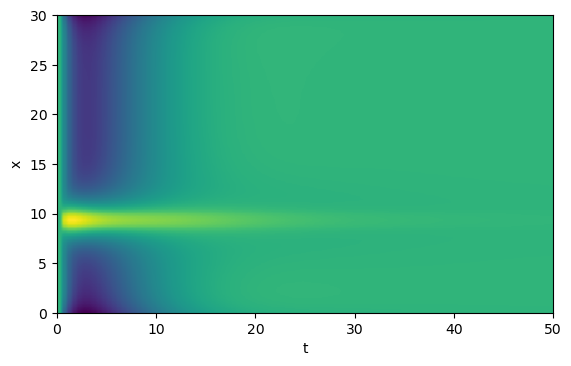

In [94]:
y = odeint(RDE_1D, y0, t, (x, D, fhn, 0, 0))
# in space and time
plt.imshow(y[:,:N+1].T, origin='lower', extent=(0, ts, 0, Lx))
plt.xlabel("t"); plt.ylabel("x");

In [27]:
D.reshape((2,1))

array([[1],
       [0]])

### Diffusion equation in 2D space
Like the case in 1D space, we discretize the space in a 2D grid, and covert the PDF to ODE.

In [10]:
def diff2D(y, t, x, D, inp=0):
    """1D Diffusion equaiton with constant boundary condition
    y: states at (x0, x1)
    t: time
    x: positions (x0, x1) in meshgrid format
    D: diffusion coefficient
    inp: function(y,x,t) or number"""
    n = np.array(x).shape[1:]  # grid size (n0, n1)
    nn = n[0]*n[1]  # grid points n0*n1
    y = y.reshape(n)  # linear to 2D
    dx = [x[0,0,1]-x[0,0,0], x[1,1,0]-x[1,0,0]]  # space step
    # Laplacian with cyclic boundary condition
    Ly = (np.roll(y,-1,0)+np.roll(y,1,0)-2*y)/dx[0]**2 + (np.roll(y,-1,1)+np.roll(y,1,1)-2*y)/dx[1]**2
    # fix the boundaris to 0 for Dirichlet condition
    Ly[0,:] = Ly[-1,:] = Ly[:,0] = Ly[:,-1] = 0
    dydt = D*Ly + (inp(y,x,t) if callable(inp) else inp)
    return dydt.ravel()

In [98]:
def diff_2D(y, t, x, D, g=0):
    """1D Diffusion equaiton with constant boundary condition
    y: linearized (ny,nx1,nx2) dim state
    t: time
    x: positions (x1, x2) in meshgrid format
    D: diffusion coefficients
    g: reaction function g(y,x,t) or constant"""
    dx = [x[0,0,1]-x[0,0,0], x[1,1,0]-x[1,0,0]]  # space step
    n = np.array(x.shape)  # 2, nx1, nx2
    n[0] = len(y)/(n[1]*n[2]) # ny
    #nn = n[0]*n[1]  # grid points n0*n1
    y = y.reshape(n)  # linear to (ny,nx1,nx2)
    # Laplacian with cyclic boundary condition
    Ly = (np.roll(y,-1,1)+np.roll(y,1,1)-2*y)/dx[0]**2 + (np.roll(y,-1,2)+np.roll(y,1,2)-2*y)/dx[1]**2
    # fix the boundaris to 0 for Dirichlet condition
    #Ly[:,0,:] = Ly[:,-1,:] = Ly[:,:,0] = Ly[:,:,-1] = 0
    dydt = D.reshape((n[0],1,1))*Ly + (g(y,x,t) if callable(g) else g)
    return dydt.ravel()

In [99]:
def fhn(y, x, t, A=[-0.005,10]):
    du = y[0] - y[0]**3 - y[1] + A[0]
    dv = (y[0] - y[1])*A[1]
    return np.array([du, dv])

In [129]:
L = 10
N = 30
x = np.array(np.meshgrid(np.linspace(0,L,N), np.linspace(0,L,N)))
ts = 2000
dt = 10.
t = np.arange(0, ts, dt)
D = np.array([0.01, 0.0005])
y0 = np.random.randn(2,N,N)  # initial condition
#y0[0,5:10,10:15] = 1  # initial bump
y = odeint(diff_2D, y0.ravel(), t, (x, D, fhn))

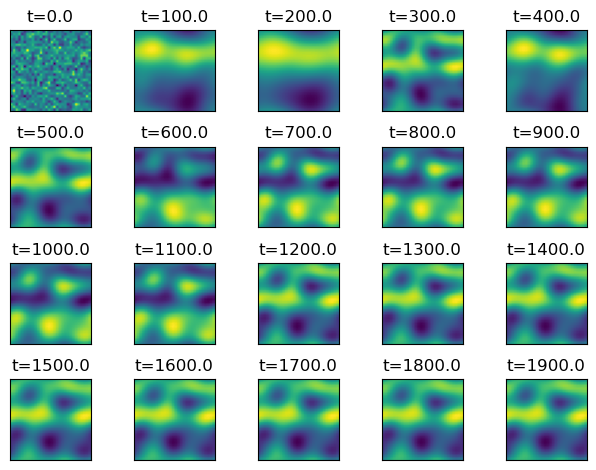

In [130]:
skip = 10
m = len(t)//skip  # frames
nc = 5  # columns
nr = int(np.ceil(m/nc))  #rows
for i in range(m):
    plt.subplot(nr, nc, i+1)
    plt.imshow(y[skip*i,:N*N].reshape(N,N).T) #, vmin=0, vmax=1, origin='lower', extent=(0,L,0,L))
    plt.title('t={:1.1f}'.format(t[skip*i]))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()

In [127]:
D = np.array([0.01, 0.1])
y0 = np.random.randn(2,N,N)  # initial condition
y = odeint(diff_2D, y0.ravel(), t, (x, D, fhn))

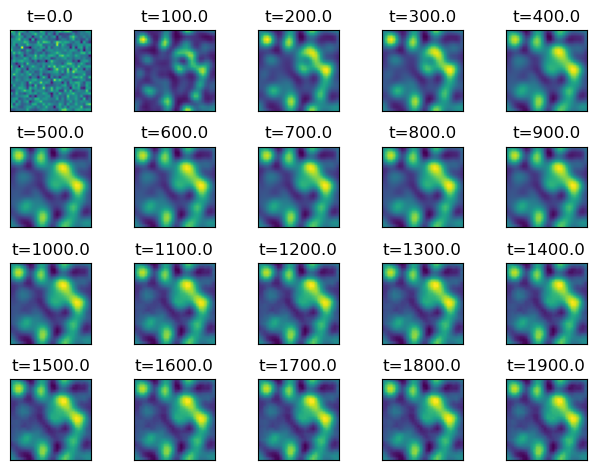

In [128]:
skip = 10
m = len(t)//skip  # frames
nc = 5  # columns
nr = int(np.ceil(m/nc))  #rows
for i in range(m):
    plt.subplot(nr, nc, i+1)
    plt.imshow(y[skip*i,:N*N].reshape(N,N).T) #, vmin=0, vmax=1, origin='lower', extent=(0,L,0,L))
    plt.title('t={:1.1f}'.format(t[skip*i]))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()

In [70]:
%matplotlib notebook

<IPython.core.display.Javascript object>


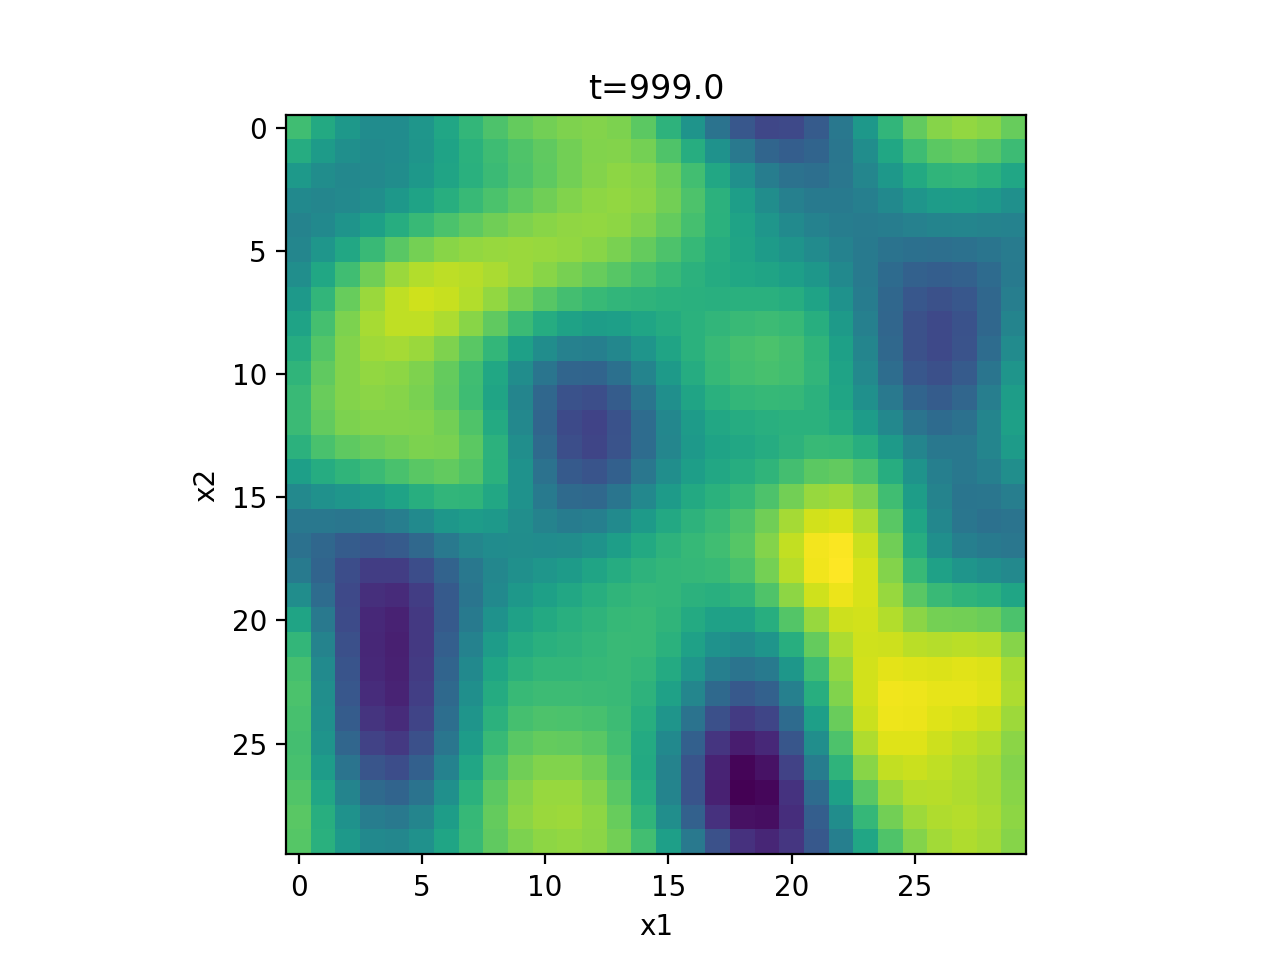

In [118]:
# animation
fig = plt.figure()
frames = []  # prepare frame
for i, ti in enumerate(t):
    p = plt.imshow(y[i,:N*N].reshape(N,N).T) #, vmin=0, vmax=1, origin='lower', extent=(0,L,0,L))
    #plt.title('t={:1.1f}'.format(t[i]))
    frames.append([p])    
anim = animation.ArtistAnimation(fig, frames, interval = 10)
plt.xlabel("x1"); plt.ylabel("x2");

In [4]:
A = np.array([[1,2],[3,4]])
B = np.array([1,2])

In [5]:
B*A

array([[1, 4],
       [3, 8]])

In [8]:
B.reshape((2,1))*A

array([[1, 2],
       [6, 8]])